<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:13:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


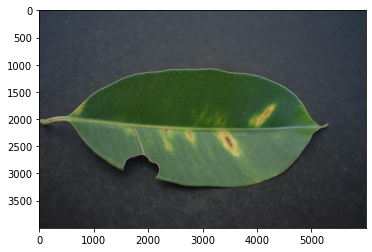

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

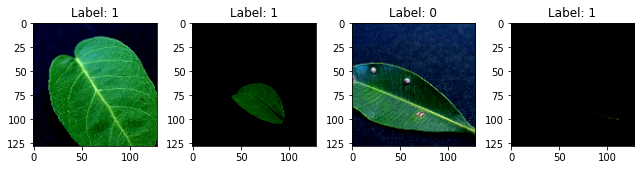

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:13:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:13:13] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2573534971956288 samples/sec                   batch loss = 1.228794813156128 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2702250276459854 samples/sec                   batch loss = 0.6164158582687378 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2756618232642989 samples/sec                   batch loss = 0.31968170404434204 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.27085958829891 samples/sec                   batch loss = 0.9712564945220947 | accuracy = 0.6625


Epoch[1] Batch[25] Speed: 1.2746187152218451 samples/sec                   batch loss = 0.48862990736961365 | accuracy = 0.64


Epoch[1] Batch[30] Speed: 1.2668919712311921 samples/sec                   batch loss = 0.5196412801742554 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.275215024920985 samples/sec                   batch loss = 0.8677170872688293 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.281335376070948 samples/sec                   batch loss = 0.3526385426521301 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.2760069293045588 samples/sec                   batch loss = 2.556901454925537 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2795238100322466 samples/sec                   batch loss = 0.7225599884986877 | accuracy = 0.64


Epoch[1] Batch[55] Speed: 1.2813680621843115 samples/sec                   batch loss = 0.42199429869651794 | accuracy = 0.6636363636363637


Epoch[1] Batch[60] Speed: 1.2758519626209162 samples/sec                   batch loss = 0.28450414538383484 | accuracy = 0.6708333333333333


Epoch[1] Batch[65] Speed: 1.2793921832942678 samples/sec                   batch loss = 0.6980158090591431 | accuracy = 0.6576923076923077


Epoch[1] Batch[70] Speed: 1.2804997067260668 samples/sec                   batch loss = 1.3600554466247559 | accuracy = 0.65


Epoch[1] Batch[75] Speed: 1.2787868929880208 samples/sec                   batch loss = 0.5919429063796997 | accuracy = 0.6533333333333333


Epoch[1] Batch[80] Speed: 1.279374914783152 samples/sec                   batch loss = 0.6512628793716431 | accuracy = 0.646875


Epoch[1] Batch[85] Speed: 1.2816917838709068 samples/sec                   batch loss = 0.5543637275695801 | accuracy = 0.6588235294117647


Epoch[1] Batch[90] Speed: 1.2780453721976415 samples/sec                   batch loss = 0.8294153809547424 | accuracy = 0.6583333333333333


Epoch[1] Batch[95] Speed: 1.2780048724593915 samples/sec                   batch loss = 0.4168055057525635 | accuracy = 0.6605263157894737


Epoch[1] Batch[100] Speed: 1.2801050867518116 samples/sec                   batch loss = 1.1951055526733398 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.275843521559592 samples/sec                   batch loss = 0.6016971468925476 | accuracy = 0.6571428571428571


Epoch[1] Batch[110] Speed: 1.281633233635056 samples/sec                   batch loss = 0.5599875450134277 | accuracy = 0.6659090909090909


Epoch[1] Batch[115] Speed: 1.2722301671864997 samples/sec                   batch loss = 0.17360693216323853 | accuracy = 0.6717391304347826


Epoch[1] Batch[120] Speed: 1.2732082027945562 samples/sec                   batch loss = 0.3638441562652588 | accuracy = 0.675


Epoch[1] Batch[125] Speed: 1.2786581464535165 samples/sec                   batch loss = 0.3279835283756256 | accuracy = 0.684


Epoch[1] Batch[130] Speed: 1.273624782686821 samples/sec                   batch loss = 0.5885785818099976 | accuracy = 0.676923076923077


Epoch[1] Batch[135] Speed: 1.274209807560113 samples/sec                   batch loss = 0.28084874153137207 | accuracy = 0.6833333333333333


Epoch[1] Batch[140] Speed: 1.275102017488365 samples/sec                   batch loss = 0.5578890442848206 | accuracy = 0.6857142857142857


Epoch[1] Batch[145] Speed: 1.2742183237937177 samples/sec                   batch loss = 0.7422751188278198 | accuracy = 0.6793103448275862


Epoch[1] Batch[150] Speed: 1.2756016889396713 samples/sec                   batch loss = 0.506371259689331 | accuracy = 0.685


Epoch[1] Batch[155] Speed: 1.2756294276172306 samples/sec                   batch loss = 0.5596003532409668 | accuracy = 0.682258064516129


Epoch[1] Batch[160] Speed: 1.2733465814723741 samples/sec                   batch loss = 0.45287010073661804 | accuracy = 0.68125


Epoch[1] Batch[165] Speed: 1.272788998547126 samples/sec                   batch loss = 1.198642611503601 | accuracy = 0.6818181818181818


Epoch[1] Batch[170] Speed: 1.2755873351326306 samples/sec                   batch loss = 0.599192202091217 | accuracy = 0.6838235294117647


Epoch[1] Batch[175] Speed: 1.2721789414139453 samples/sec                   batch loss = 1.2119756937026978 | accuracy = 0.6828571428571428


Epoch[1] Batch[180] Speed: 1.2689863118099072 samples/sec                   batch loss = 0.4711606502532959 | accuracy = 0.6847222222222222


Epoch[1] Batch[185] Speed: 1.2726161813373926 samples/sec                   batch loss = 0.26340633630752563 | accuracy = 0.6878378378378378


Epoch[1] Batch[190] Speed: 1.2680215535947423 samples/sec                   batch loss = 0.2955896258354187 | accuracy = 0.6894736842105263


Epoch[1] Batch[195] Speed: 1.2732571923647749 samples/sec                   batch loss = 0.3308252692222595 | accuracy = 0.6961538461538461


Epoch[1] Batch[200] Speed: 1.275323883779103 samples/sec                   batch loss = 0.8149948716163635 | accuracy = 0.6975


Epoch[1] Batch[205] Speed: 1.2695038707754467 samples/sec                   batch loss = 0.6981136202812195 | accuracy = 0.7


Epoch[1] Batch[210] Speed: 1.2769539457650536 samples/sec                   batch loss = 0.3129664659500122 | accuracy = 0.6988095238095238


Epoch[1] Batch[215] Speed: 1.2679132669918747 samples/sec                   batch loss = 0.17729605734348297 | accuracy = 0.7023255813953488


Epoch[1] Batch[220] Speed: 1.2741690666993135 samples/sec                   batch loss = 0.23325063288211823 | accuracy = 0.7068181818181818


Epoch[1] Batch[225] Speed: 1.2702913886906833 samples/sec                   batch loss = 0.4658757746219635 | accuracy = 0.7066666666666667


Epoch[1] Batch[230] Speed: 1.2732020189747688 samples/sec                   batch loss = 1.0356231927871704 | accuracy = 0.7054347826086956


Epoch[1] Batch[235] Speed: 1.2741743889916153 samples/sec                   batch loss = 0.2902800738811493 | accuracy = 0.7053191489361702


Epoch[1] Batch[240] Speed: 1.2721696806976348 samples/sec                   batch loss = 0.5762771368026733 | accuracy = 0.703125


Epoch[1] Batch[245] Speed: 1.2762298872958302 samples/sec                   batch loss = 0.5041002631187439 | accuracy = 0.7040816326530612


Epoch[1] Batch[250] Speed: 1.278703463056639 samples/sec                   batch loss = 0.18578645586967468 | accuracy = 0.709


Epoch[1] Batch[255] Speed: 1.2784067707366955 samples/sec                   batch loss = 0.37094902992248535 | accuracy = 0.7127450980392157


Epoch[1] Batch[260] Speed: 1.2789531030393593 samples/sec                   batch loss = 1.2040578126907349 | accuracy = 0.7125


Epoch[1] Batch[265] Speed: 1.2745730098642338 samples/sec                   batch loss = 1.2121964693069458 | accuracy = 0.710377358490566


Epoch[1] Batch[270] Speed: 1.2828335046992911 samples/sec                   batch loss = 0.467011421918869 | accuracy = 0.7111111111111111


Epoch[1] Batch[275] Speed: 1.2798119416961893 samples/sec                   batch loss = 0.37526416778564453 | accuracy = 0.7118181818181818


Epoch[1] Batch[280] Speed: 1.2771626511201501 samples/sec                   batch loss = 0.8745741844177246 | accuracy = 0.7098214285714286


Epoch[1] Batch[285] Speed: 1.2761712525683595 samples/sec                   batch loss = 0.5944602489471436 | accuracy = 0.7087719298245614


Epoch[1] Batch[290] Speed: 1.281988239817735 samples/sec                   batch loss = 0.43948835134506226 | accuracy = 0.7103448275862069


Epoch[1] Batch[295] Speed: 1.2737297922223236 samples/sec                   batch loss = 0.6342247724533081 | accuracy = 0.711864406779661


Epoch[1] Batch[300] Speed: 1.2790257421105018 samples/sec                   batch loss = 0.6559026837348938 | accuracy = 0.7091666666666666


Epoch[1] Batch[305] Speed: 1.2790960489882066 samples/sec                   batch loss = 0.47436267137527466 | accuracy = 0.7098360655737705


Epoch[1] Batch[310] Speed: 1.2716208382751353 samples/sec                   batch loss = 0.301013320684433 | accuracy = 0.707258064516129


Epoch[1] Batch[315] Speed: 1.2790403684247522 samples/sec                   batch loss = 0.6024324297904968 | accuracy = 0.707936507936508


Epoch[1] Batch[320] Speed: 1.280078618109709 samples/sec                   batch loss = 0.17022743821144104 | accuracy = 0.71015625


Epoch[1] Batch[325] Speed: 1.2782872557993814 samples/sec                   batch loss = 0.3612977862358093 | accuracy = 0.71


Epoch[1] Batch[330] Speed: 1.2781219003447997 samples/sec                   batch loss = 0.4750055968761444 | accuracy = 0.7121212121212122


Epoch[1] Batch[335] Speed: 1.279486924493779 samples/sec                   batch loss = 0.5203781127929688 | accuracy = 0.7126865671641791


Epoch[1] Batch[340] Speed: 1.2788099940873807 samples/sec                   batch loss = 0.6900597214698792 | accuracy = 0.7139705882352941


Epoch[1] Batch[345] Speed: 1.2792345400621257 samples/sec                   batch loss = 0.3907553255558014 | accuracy = 0.7144927536231884


Epoch[1] Batch[350] Speed: 1.2786895266409783 samples/sec                   batch loss = 0.7389146089553833 | accuracy = 0.7121428571428572


Epoch[1] Batch[355] Speed: 1.2779597027024268 samples/sec                   batch loss = 0.3373296558856964 | accuracy = 0.7147887323943662


Epoch[1] Batch[360] Speed: 1.2816460593997143 samples/sec                   batch loss = 0.535297691822052 | accuracy = 0.7125


Epoch[1] Batch[365] Speed: 1.2862480259371485 samples/sec                   batch loss = 0.750613808631897 | accuracy = 0.7123287671232876


Epoch[1] Batch[370] Speed: 1.2747682488699752 samples/sec                   batch loss = 0.2012338936328888 | accuracy = 0.7114864864864865


Epoch[1] Batch[375] Speed: 1.2813611137990895 samples/sec                   batch loss = 0.7823933362960815 | accuracy = 0.7086666666666667


Epoch[1] Batch[380] Speed: 1.2824541102595162 samples/sec                   batch loss = 0.9094861745834351 | accuracy = 0.7078947368421052


Epoch[1] Batch[385] Speed: 1.2801330216350912 samples/sec                   batch loss = 0.8320038318634033 | accuracy = 0.7051948051948052


Epoch[1] Batch[390] Speed: 1.2781183950385542 samples/sec                   batch loss = 0.363198846578598 | accuracy = 0.7070512820512821


Epoch[1] Batch[395] Speed: 1.2753305729525761 samples/sec                   batch loss = 0.3263748586177826 | accuracy = 0.7082278481012658


Epoch[1] Batch[400] Speed: 1.2799822268092895 samples/sec                   batch loss = 0.7865464687347412 | accuracy = 0.7075


Epoch[1] Batch[405] Speed: 1.2813857760143283 samples/sec                   batch loss = 0.9082046151161194 | accuracy = 0.7074074074074074


Epoch[1] Batch[410] Speed: 1.2794191113943552 samples/sec                   batch loss = 0.8093671798706055 | accuracy = 0.7067073170731707


Epoch[1] Batch[415] Speed: 1.2742220980700154 samples/sec                   batch loss = 0.3378857374191284 | accuracy = 0.7078313253012049


Epoch[1] Batch[420] Speed: 1.2713004492799933 samples/sec                   batch loss = 0.24270658195018768 | accuracy = 0.7071428571428572


Epoch[1] Batch[425] Speed: 1.2828263442359042 samples/sec                   batch loss = 0.38432440161705017 | accuracy = 0.7088235294117647


Epoch[1] Batch[430] Speed: 1.2765356712066276 samples/sec                   batch loss = 0.49978309869766235 | accuracy = 0.7087209302325581


Epoch[1] Batch[435] Speed: 1.2744891606764726 samples/sec                   batch loss = 0.6223855018615723 | accuracy = 0.7086206896551724


Epoch[1] Batch[440] Speed: 1.2802055994252617 samples/sec                   batch loss = 0.23969830572605133 | accuracy = 0.709659090909091


Epoch[1] Batch[445] Speed: 1.2789475457589297 samples/sec                   batch loss = 0.4738476574420929 | accuracy = 0.7095505617977528


Epoch[1] Batch[450] Speed: 1.2778580824225751 samples/sec                   batch loss = 0.4268586337566376 | accuracy = 0.7088888888888889


Epoch[1] Batch[455] Speed: 1.2726282480541031 samples/sec                   batch loss = 0.3529089391231537 | accuracy = 0.7076923076923077


Epoch[1] Batch[460] Speed: 1.272915793193793 samples/sec                   batch loss = 0.34457868337631226 | accuracy = 0.7092391304347826


Epoch[1] Batch[465] Speed: 1.2763080429497955 samples/sec                   batch loss = 0.6129041910171509 | accuracy = 0.7075268817204301


Epoch[1] Batch[470] Speed: 1.274075401631968 samples/sec                   batch loss = 0.4103643596172333 | accuracy = 0.7074468085106383


Epoch[1] Batch[475] Speed: 1.2789039666551638 samples/sec                   batch loss = 0.32231903076171875 | accuracy = 0.7063157894736842


Epoch[1] Batch[480] Speed: 1.2872464574515932 samples/sec                   batch loss = 0.8219071626663208 | accuracy = 0.7052083333333333


Epoch[1] Batch[485] Speed: 1.2728032894451848 samples/sec                   batch loss = 0.42853042483329773 | accuracy = 0.7067010309278351


Epoch[1] Batch[490] Speed: 1.2790139437940948 samples/sec                   batch loss = 0.394840270280838 | accuracy = 0.7066326530612245


Epoch[1] Batch[495] Speed: 1.281184200026193 samples/sec                   batch loss = 0.9069697856903076 | accuracy = 0.704040404040404


Epoch[1] Batch[500] Speed: 1.2764130098872233 samples/sec                   batch loss = 0.4001649022102356 | accuracy = 0.704


Epoch[1] Batch[505] Speed: 1.2797626416792356 samples/sec                   batch loss = 0.6308923363685608 | accuracy = 0.7049504950495049


Epoch[1] Batch[510] Speed: 1.2752292734205493 samples/sec                   batch loss = 0.6160574555397034 | accuracy = 0.7053921568627451


Epoch[1] Batch[515] Speed: 1.2747256320797287 samples/sec                   batch loss = 0.3711376190185547 | accuracy = 0.7048543689320388


Epoch[1] Batch[520] Speed: 1.2758855339242623 samples/sec                   batch loss = 0.45744189620018005 | accuracy = 0.7057692307692308


Epoch[1] Batch[525] Speed: 1.280721206911332 samples/sec                   batch loss = 1.0249485969543457 | accuracy = 0.7057142857142857


Epoch[1] Batch[530] Speed: 1.2746577416701577 samples/sec                   batch loss = 0.49212855100631714 | accuracy = 0.7056603773584905


Epoch[1] Batch[535] Speed: 1.2857462869064862 samples/sec                   batch loss = 1.0927842855453491 | accuracy = 0.705607476635514


Epoch[1] Batch[540] Speed: 1.279212398982255 samples/sec                   batch loss = 0.4526901841163635 | accuracy = 0.7064814814814815


Epoch[1] Batch[545] Speed: 1.2753696430052421 samples/sec                   batch loss = 0.7312251925468445 | accuracy = 0.7055045871559633


Epoch[1] Batch[550] Speed: 1.2776922541485052 samples/sec                   batch loss = 0.38066211342811584 | accuracy = 0.7063636363636364


Epoch[1] Batch[555] Speed: 1.2783215397873124 samples/sec                   batch loss = 0.34334513545036316 | accuracy = 0.7063063063063063


Epoch[1] Batch[560] Speed: 1.2764495241735596 samples/sec                   batch loss = 0.47493746876716614 | accuracy = 0.7058035714285714


Epoch[1] Batch[565] Speed: 1.273326286627772 samples/sec                   batch loss = 0.25299879908561707 | accuracy = 0.7070796460176991


Epoch[1] Batch[570] Speed: 1.2762134806785501 samples/sec                   batch loss = 0.8790069222450256 | accuracy = 0.706140350877193


Epoch[1] Batch[575] Speed: 1.279568797654782 samples/sec                   batch loss = 0.7297031879425049 | accuracy = 0.7065217391304348


Epoch[1] Batch[580] Speed: 1.2728719481662443 samples/sec                   batch loss = 0.4692261517047882 | accuracy = 0.7064655172413793


Epoch[1] Batch[585] Speed: 1.2777441195167742 samples/sec                   batch loss = 0.2587674856185913 | accuracy = 0.7076923076923077


Epoch[1] Batch[590] Speed: 1.27700827841147 samples/sec                   batch loss = 0.5226730108261108 | accuracy = 0.7059322033898305


Epoch[1] Batch[595] Speed: 1.2758242142645304 samples/sec                   batch loss = 0.46450233459472656 | accuracy = 0.7050420168067227


Epoch[1] Batch[600] Speed: 1.2747033562552088 samples/sec                   batch loss = 0.8090799450874329 | accuracy = 0.7054166666666667


Epoch[1] Batch[605] Speed: 1.2792902375330093 samples/sec                   batch loss = 0.3992186486721039 | accuracy = 0.7057851239669422


Epoch[1] Batch[610] Speed: 1.2747094578166789 samples/sec                   batch loss = 0.8587639331817627 | accuracy = 0.7065573770491803


Epoch[1] Batch[615] Speed: 1.2774588634531545 samples/sec                   batch loss = 0.32076069712638855 | accuracy = 0.7052845528455285


Epoch[1] Batch[620] Speed: 1.2794105255002215 samples/sec                   batch loss = 0.4850683808326721 | accuracy = 0.7040322580645161


Epoch[1] Batch[625] Speed: 1.2738945934702144 samples/sec                   batch loss = 0.6569249629974365 | accuracy = 0.7044


Epoch[1] Batch[630] Speed: 1.2803680745624506 samples/sec                   batch loss = 2.4959726333618164 | accuracy = 0.7055555555555556


Epoch[1] Batch[635] Speed: 1.280190360337242 samples/sec                   batch loss = 0.9253435134887695 | accuracy = 0.7043307086614173


Epoch[1] Batch[640] Speed: 1.2736322275439902 samples/sec                   batch loss = 0.38417014479637146 | accuracy = 0.705859375


Epoch[1] Batch[645] Speed: 1.2744951633694583 samples/sec                   batch loss = 0.22033999860286713 | accuracy = 0.7054263565891473


Epoch[1] Batch[650] Speed: 1.2743359175199223 samples/sec                   batch loss = 0.5578232407569885 | accuracy = 0.705


Epoch[1] Batch[655] Speed: 1.277552734827724 samples/sec                   batch loss = 0.3386571407318115 | accuracy = 0.7049618320610687


Epoch[1] Batch[660] Speed: 1.2732183482540127 samples/sec                   batch loss = 0.4814455807209015 | accuracy = 0.7041666666666667


Epoch[1] Batch[665] Speed: 1.2766226070007052 samples/sec                   batch loss = 0.7240418195724487 | accuracy = 0.7045112781954888


Epoch[1] Batch[670] Speed: 1.2780321316161898 samples/sec                   batch loss = 0.6127257943153381 | accuracy = 0.7029850746268657


Epoch[1] Batch[675] Speed: 1.2762280427438466 samples/sec                   batch loss = 0.3199930191040039 | accuracy = 0.7022222222222222


Epoch[1] Batch[680] Speed: 1.2739430554709748 samples/sec                   batch loss = 0.5550671815872192 | accuracy = 0.7022058823529411


Epoch[1] Batch[685] Speed: 1.27268298555432 samples/sec                   batch loss = 0.7259427309036255 | accuracy = 0.7029197080291971


Epoch[1] Batch[690] Speed: 1.275172862858851 samples/sec                   batch loss = 0.566826343536377 | accuracy = 0.7028985507246377


Epoch[1] Batch[695] Speed: 1.276660299046805 samples/sec                   batch loss = 1.5742088556289673 | accuracy = 0.7014388489208633


Epoch[1] Batch[700] Speed: 1.278510134598095 samples/sec                   batch loss = 0.4872343838214874 | accuracy = 0.7021428571428572


Epoch[1] Batch[705] Speed: 1.2756877215668136 samples/sec                   batch loss = 0.2985699772834778 | accuracy = 0.7031914893617022


Epoch[1] Batch[710] Speed: 1.279214252171003 samples/sec                   batch loss = 0.5878851413726807 | accuracy = 0.702112676056338


Epoch[1] Batch[715] Speed: 1.2767345239120766 samples/sec                   batch loss = 1.0375350713729858 | accuracy = 0.7017482517482517


Epoch[1] Batch[720] Speed: 1.2734429424904874 samples/sec                   batch loss = 0.3293027877807617 | accuracy = 0.7010416666666667


Epoch[1] Batch[725] Speed: 1.2809066964973528 samples/sec                   batch loss = 0.4729849100112915 | accuracy = 0.7003448275862069


Epoch[1] Batch[730] Speed: 1.277754142765729 samples/sec                   batch loss = 0.2329765111207962 | accuracy = 0.7013698630136986


Epoch[1] Batch[735] Speed: 1.2712708756402873 samples/sec                   batch loss = 0.8208306431770325 | accuracy = 0.7010204081632653


Epoch[1] Batch[740] Speed: 1.2814225753703472 samples/sec                   batch loss = 0.5172164440155029 | accuracy = 0.7010135135135135


Epoch[1] Batch[745] Speed: 1.277069323107167 samples/sec                   batch loss = 0.2646702527999878 | accuracy = 0.7030201342281879


Epoch[1] Batch[750] Speed: 1.2816807196204252 samples/sec                   batch loss = 0.43140098452568054 | accuracy = 0.7036666666666667


Epoch[1] Batch[755] Speed: 1.2838471729593142 samples/sec                   batch loss = 0.6337382793426514 | accuracy = 0.7043046357615894


Epoch[1] Batch[760] Speed: 1.2748316950522092 samples/sec                   batch loss = 0.7480490207672119 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.2758155795327353 samples/sec                   batch loss = 0.3835967183113098 | accuracy = 0.7045751633986929


Epoch[1] Batch[770] Speed: 1.2727556865509455 samples/sec                   batch loss = 0.5077822804450989 | accuracy = 0.7042207792207792


Epoch[1] Batch[775] Speed: 1.277986667884434 samples/sec                   batch loss = 0.90291428565979 | accuracy = 0.7035483870967741


Epoch[1] Batch[780] Speed: 1.2773818311391028 samples/sec                   batch loss = 0.5066547989845276 | accuracy = 0.7035256410256411


Epoch[1] Batch[785] Speed: 1.2791250125989562 samples/sec                   batch loss = 0.43940895795822144 | accuracy = 0.7031847133757961


[Epoch 1] training: accuracy=0.7027284263959391
[Epoch 1] time cost: 644.2443768978119
[Epoch 1] validation: validation accuracy=0.7766666666666666


Epoch[2] Batch[5] Speed: 1.2736429598938586 samples/sec                   batch loss = 0.5297760367393494 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.279288871862763 samples/sec                   batch loss = 0.32142210006713867 | accuracy = 0.6


Epoch[2] Batch[15] Speed: 1.274549674282567 samples/sec                   batch loss = 0.8728593587875366 | accuracy = 0.5666666666666667


Epoch[2] Batch[20] Speed: 1.2795825580582996 samples/sec                   batch loss = 0.43892401456832886 | accuracy = 0.6


Epoch[2] Batch[25] Speed: 1.2764274793944104 samples/sec                   batch loss = 0.35267776250839233 | accuracy = 0.63


Epoch[2] Batch[30] Speed: 1.2760674900721372 samples/sec                   batch loss = 0.6977819204330444 | accuracy = 0.65


Epoch[2] Batch[35] Speed: 1.2795334708818555 samples/sec                   batch loss = 0.35275980830192566 | accuracy = 0.65


Epoch[2] Batch[40] Speed: 1.2748721876728735 samples/sec                   batch loss = 0.812002956867218 | accuracy = 0.65625


Epoch[2] Batch[45] Speed: 1.266142581803327 samples/sec                   batch loss = 0.18584215641021729 | accuracy = 0.6777777777777778


Epoch[2] Batch[50] Speed: 1.2719940420162799 samples/sec                   batch loss = 0.5836291909217834 | accuracy = 0.685


Epoch[2] Batch[55] Speed: 1.2736884051815076 samples/sec                   batch loss = 0.352117121219635 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.27660764737259 samples/sec                   batch loss = 0.3744521737098694 | accuracy = 0.6916666666666667


Epoch[2] Batch[65] Speed: 1.2712060496414839 samples/sec                   batch loss = 0.2702077329158783 | accuracy = 0.7


Epoch[2] Batch[70] Speed: 1.2773003348406913 samples/sec                   batch loss = 0.4268510937690735 | accuracy = 0.7035714285714286


Epoch[2] Batch[75] Speed: 1.2763649424030332 samples/sec                   batch loss = 0.23106956481933594 | accuracy = 0.7066666666666667


Epoch[2] Batch[80] Speed: 1.2787278281494852 samples/sec                   batch loss = 0.4166228473186493 | accuracy = 0.7125


Epoch[2] Batch[85] Speed: 1.2751001761951886 samples/sec                   batch loss = 0.6297884583473206 | accuracy = 0.7088235294117647


Epoch[2] Batch[90] Speed: 1.2731445316501766 samples/sec                   batch loss = 0.5520583987236023 | accuracy = 0.7111111111111111


Epoch[2] Batch[95] Speed: 1.271004774786111 samples/sec                   batch loss = 0.5018128752708435 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2720575016875755 samples/sec                   batch loss = 0.33638280630111694 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2762198879463393 samples/sec                   batch loss = 1.0927186012268066 | accuracy = 0.7214285714285714


Epoch[2] Batch[110] Speed: 1.2696642172258001 samples/sec                   batch loss = 0.5322019457817078 | accuracy = 0.7227272727272728


Epoch[2] Batch[115] Speed: 1.277138734516976 samples/sec                   batch loss = 0.22344867885112762 | accuracy = 0.7239130434782609


Epoch[2] Batch[120] Speed: 1.2813783381034027 samples/sec                   batch loss = 0.5216322541236877 | accuracy = 0.71875


Epoch[2] Batch[125] Speed: 1.273170231224225 samples/sec                   batch loss = 0.744775116443634 | accuracy = 0.714


Epoch[2] Batch[130] Speed: 1.2747141066646244 samples/sec                   batch loss = 0.18334178626537323 | accuracy = 0.7134615384615385


Epoch[2] Batch[135] Speed: 1.2737498098168807 samples/sec                   batch loss = 0.16043491661548615 | accuracy = 0.7166666666666667


Epoch[2] Batch[140] Speed: 1.272671110881854 samples/sec                   batch loss = 0.6550328731536865 | accuracy = 0.7125


Epoch[2] Batch[145] Speed: 1.272836024535975 samples/sec                   batch loss = 0.43602487444877625 | accuracy = 0.7189655172413794


Epoch[2] Batch[150] Speed: 1.276385916860014 samples/sec                   batch loss = 0.2514551877975464 | accuracy = 0.72


Epoch[2] Batch[155] Speed: 1.277587076714777 samples/sec                   batch loss = 0.32074955105781555 | accuracy = 0.7241935483870968


Epoch[2] Batch[160] Speed: 1.2747748353554176 samples/sec                   batch loss = 0.4890793263912201 | accuracy = 0.728125


Epoch[2] Batch[165] Speed: 1.2821594965397347 samples/sec                   batch loss = 0.15954089164733887 | accuracy = 0.7287878787878788


Epoch[2] Batch[170] Speed: 1.2681435658812774 samples/sec                   batch loss = 1.0113123655319214 | accuracy = 0.7294117647058823


Epoch[2] Batch[175] Speed: 1.267705561813697 samples/sec                   batch loss = 0.5276185870170593 | accuracy = 0.7314285714285714


Epoch[2] Batch[180] Speed: 1.2677208882833177 samples/sec                   batch loss = 0.2976367771625519 | accuracy = 0.7333333333333333


Epoch[2] Batch[185] Speed: 1.265969080931259 samples/sec                   batch loss = 0.7346555590629578 | accuracy = 0.731081081081081


Epoch[2] Batch[190] Speed: 1.27591056801131 samples/sec                   batch loss = 0.34621676802635193 | accuracy = 0.7315789473684211


Epoch[2] Batch[195] Speed: 1.279979883128668 samples/sec                   batch loss = 0.5764307975769043 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.2732008595152458 samples/sec                   batch loss = 0.5376006960868835 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.2737772745935991 samples/sec                   batch loss = 0.24323789775371552 | accuracy = 0.7414634146341463


Epoch[2] Batch[210] Speed: 1.2723476836964815 samples/sec                   batch loss = 0.24625691771507263 | accuracy = 0.736904761904762


Epoch[2] Batch[215] Speed: 1.272896284680799 samples/sec                   batch loss = 0.2901749908924103 | accuracy = 0.7348837209302326


Epoch[2] Batch[220] Speed: 1.272010243883614 samples/sec                   batch loss = 0.487885057926178 | accuracy = 0.7375


Epoch[2] Batch[225] Speed: 1.2722421301079652 samples/sec                   batch loss = 1.008711576461792 | accuracy = 0.7388888888888889


Epoch[2] Batch[230] Speed: 1.276495169969417 samples/sec                   batch loss = 0.18526707589626312 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.266018183732136 samples/sec                   batch loss = 0.5599689483642578 | accuracy = 0.7414893617021276


Epoch[2] Batch[240] Speed: 1.270329381105341 samples/sec                   batch loss = 0.36526915431022644 | accuracy = 0.74375


Epoch[2] Batch[245] Speed: 1.2782132398239094 samples/sec                   batch loss = 0.24222499132156372 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2748002133327174 samples/sec                   batch loss = 0.17694611847400665 | accuracy = 0.742


Epoch[2] Batch[255] Speed: 1.2753793381780958 samples/sec                   batch loss = 0.295937716960907 | accuracy = 0.7421568627450981


Epoch[2] Batch[260] Speed: 1.2788496675430046 samples/sec                   batch loss = 0.717394232749939 | accuracy = 0.7403846153846154


Epoch[2] Batch[265] Speed: 1.2738242769240253 samples/sec                   batch loss = 0.4796225130558014 | accuracy = 0.7424528301886792


Epoch[2] Batch[270] Speed: 1.2696576834452755 samples/sec                   batch loss = 0.48905694484710693 | accuracy = 0.7444444444444445


Epoch[2] Batch[275] Speed: 1.2703598728641843 samples/sec                   batch loss = 0.16298222541809082 | accuracy = 0.7481818181818182


Epoch[2] Batch[280] Speed: 1.273932124597872 samples/sec                   batch loss = 0.9831246137619019 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.2689388020409857 samples/sec                   batch loss = 0.5594795942306519 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.277091098423505 samples/sec                   batch loss = 0.21380369365215302 | accuracy = 0.7508620689655172


Epoch[2] Batch[295] Speed: 1.2731684921225752 samples/sec                   batch loss = 0.6963708996772766 | accuracy = 0.752542372881356


Epoch[2] Batch[300] Speed: 1.278749465130307 samples/sec                   batch loss = 0.2541954815387726 | accuracy = 0.7525


Epoch[2] Batch[305] Speed: 1.274038249056425 samples/sec                   batch loss = 0.4825475811958313 | accuracy = 0.7508196721311475


Epoch[2] Batch[310] Speed: 1.2716195853119785 samples/sec                   batch loss = 0.5011336803436279 | accuracy = 0.7524193548387097


Epoch[2] Batch[315] Speed: 1.2748487442631786 samples/sec                   batch loss = 0.3791253864765167 | accuracy = 0.7523809523809524


Epoch[2] Batch[320] Speed: 1.2794577493440547 samples/sec                   batch loss = 0.1254519820213318 | accuracy = 0.75390625


Epoch[2] Batch[325] Speed: 1.2796974348182295 samples/sec                   batch loss = 0.1866004914045334 | accuracy = 0.7546153846153846


Epoch[2] Batch[330] Speed: 1.2788808621605696 samples/sec                   batch loss = 0.32866817712783813 | accuracy = 0.7545454545454545


Epoch[2] Batch[335] Speed: 1.2742821023887716 samples/sec                   batch loss = 0.3735017478466034 | accuracy = 0.7559701492537313


Epoch[2] Batch[340] Speed: 1.2737148036141848 samples/sec                   batch loss = 0.6299543380737305 | accuracy = 0.7573529411764706


Epoch[2] Batch[345] Speed: 1.272729617509354 samples/sec                   batch loss = 0.3083436191082001 | accuracy = 0.758695652173913


Epoch[2] Batch[350] Speed: 1.2677798986514568 samples/sec                   batch loss = 0.515772819519043 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2686675366320483 samples/sec                   batch loss = 0.5006227493286133 | accuracy = 0.7591549295774648


Epoch[2] Batch[360] Speed: 1.2699909920139283 samples/sec                   batch loss = 1.0582139492034912 | accuracy = 0.7576388888888889


Epoch[2] Batch[365] Speed: 1.27368337703268 samples/sec                   batch loss = 0.7933441996574402 | accuracy = 0.7547945205479452


Epoch[2] Batch[370] Speed: 1.2715210908581334 samples/sec                   batch loss = 0.1361602544784546 | accuracy = 0.7560810810810811


Epoch[2] Batch[375] Speed: 1.2690525434845539 samples/sec                   batch loss = 1.282460331916809 | accuracy = 0.756


Epoch[2] Batch[380] Speed: 1.2723164210276456 samples/sec                   batch loss = 0.24324846267700195 | accuracy = 0.7585526315789474


Epoch[2] Batch[385] Speed: 1.2710948109209255 samples/sec                   batch loss = 0.5196226239204407 | accuracy = 0.759090909090909


Epoch[2] Batch[390] Speed: 1.2690047407990777 samples/sec                   batch loss = 0.8032712936401367 | accuracy = 0.7576923076923077


Epoch[2] Batch[395] Speed: 1.276186493196181 samples/sec                   batch loss = 0.3279631435871124 | accuracy = 0.7569620253164557


Epoch[2] Batch[400] Speed: 1.2755582405688444 samples/sec                   batch loss = 0.8064302802085876 | accuracy = 0.758125


Epoch[2] Batch[405] Speed: 1.279233662207363 samples/sec                   batch loss = 0.3033144772052765 | accuracy = 0.7604938271604939


Epoch[2] Batch[410] Speed: 1.2779896857192872 samples/sec                   batch loss = 0.1500350385904312 | accuracy = 0.7603658536585366


Epoch[2] Batch[415] Speed: 1.2783389746797356 samples/sec                   batch loss = 1.2740639448165894 | accuracy = 0.7584337349397591


Epoch[2] Batch[420] Speed: 1.2728556277710352 samples/sec                   batch loss = 0.5012325048446655 | accuracy = 0.7595238095238095


Epoch[2] Batch[425] Speed: 1.2750878687405256 samples/sec                   batch loss = 0.5565211772918701 | accuracy = 0.76


Epoch[2] Batch[430] Speed: 1.2691664973407382 samples/sec                   batch loss = 0.2716345489025116 | accuracy = 0.7587209302325582


Epoch[2] Batch[435] Speed: 1.2737970035444461 samples/sec                   batch loss = 0.2897774577140808 | accuracy = 0.7603448275862069


Epoch[2] Batch[440] Speed: 1.2693126416675997 samples/sec                   batch loss = 0.3784363269805908 | accuracy = 0.7607954545454545


Epoch[2] Batch[445] Speed: 1.2681326384506442 samples/sec                   batch loss = 0.6264960169792175 | accuracy = 0.7612359550561798


Epoch[2] Batch[450] Speed: 1.2704111446418334 samples/sec                   batch loss = 0.1086951419711113 | accuracy = 0.7633333333333333


Epoch[2] Batch[455] Speed: 1.2697057275198305 samples/sec                   batch loss = 0.17295870184898376 | accuracy = 0.7626373626373626


Epoch[2] Batch[460] Speed: 1.2710409802973381 samples/sec                   batch loss = 0.5568327903747559 | accuracy = 0.7630434782608696


Epoch[2] Batch[465] Speed: 1.2737664432726075 samples/sec                   batch loss = 0.17529380321502686 | accuracy = 0.7629032258064516


Epoch[2] Batch[470] Speed: 1.274600025982452 samples/sec                   batch loss = 0.7242398858070374 | accuracy = 0.7617021276595745


Epoch[2] Batch[475] Speed: 1.2790303249863137 samples/sec                   batch loss = 0.23789618909358978 | accuracy = 0.7626315789473684


Epoch[2] Batch[480] Speed: 1.2786851411184696 samples/sec                   batch loss = 0.3421493470668793 | accuracy = 0.7635416666666667


Epoch[2] Batch[485] Speed: 1.2754592320142 samples/sec                   batch loss = 0.3590466380119324 | accuracy = 0.7644329896907216


Epoch[2] Batch[490] Speed: 1.2784363850640135 samples/sec                   batch loss = 0.35039106011390686 | accuracy = 0.7642857142857142


Epoch[2] Batch[495] Speed: 1.2768069111830391 samples/sec                   batch loss = 1.2643194198608398 | accuracy = 0.7651515151515151


Epoch[2] Batch[500] Speed: 1.269272789515792 samples/sec                   batch loss = 0.5693448781967163 | accuracy = 0.7645


Epoch[2] Batch[505] Speed: 1.2783273838323421 samples/sec                   batch loss = 0.41614317893981934 | accuracy = 0.7658415841584159


Epoch[2] Batch[510] Speed: 1.2775091534480654 samples/sec                   batch loss = 0.22870835661888123 | accuracy = 0.7676470588235295


Epoch[2] Batch[515] Speed: 1.2764201960444188 samples/sec                   batch loss = 0.5837212204933167 | accuracy = 0.766504854368932


Epoch[2] Batch[520] Speed: 1.2731488792495644 samples/sec                   batch loss = 0.38866814970970154 | accuracy = 0.7658653846153847


Epoch[2] Batch[525] Speed: 1.277545827759007 samples/sec                   batch loss = 0.49897316098213196 | accuracy = 0.7652380952380953


Epoch[2] Batch[530] Speed: 1.2753485080393356 samples/sec                   batch loss = 0.21244584023952484 | accuracy = 0.7660377358490567


Epoch[2] Batch[535] Speed: 1.2777403243470487 samples/sec                   batch loss = 0.26781541109085083 | accuracy = 0.766822429906542


Epoch[2] Batch[540] Speed: 1.2721173987660992 samples/sec                   batch loss = 0.2711893320083618 | accuracy = 0.7666666666666667


Epoch[2] Batch[545] Speed: 1.2711821629760782 samples/sec                   batch loss = 0.5300740003585815 | accuracy = 0.7655963302752293


Epoch[2] Batch[550] Speed: 1.2725396354168168 samples/sec                   batch loss = 0.7670813202857971 | accuracy = 0.764090909090909


Epoch[2] Batch[555] Speed: 1.2735655169932307 samples/sec                   batch loss = 0.48155301809310913 | accuracy = 0.763063063063063


Epoch[2] Batch[560] Speed: 1.27135719213501 samples/sec                   batch loss = 0.4496099054813385 | accuracy = 0.7647321428571429


Epoch[2] Batch[565] Speed: 1.2742825863175393 samples/sec                   batch loss = 0.2083522379398346 | accuracy = 0.765929203539823


Epoch[2] Batch[570] Speed: 1.2730066798414623 samples/sec                   batch loss = 0.5542545318603516 | accuracy = 0.7666666666666667


Epoch[2] Batch[575] Speed: 1.2721085247689088 samples/sec                   batch loss = 0.22221636772155762 | accuracy = 0.7660869565217391


Epoch[2] Batch[580] Speed: 1.2746998696748801 samples/sec                   batch loss = 0.5669471025466919 | accuracy = 0.7650862068965517


Epoch[2] Batch[585] Speed: 1.273609796549964 samples/sec                   batch loss = 0.4813494086265564 | accuracy = 0.7653846153846153


Epoch[2] Batch[590] Speed: 1.2711643448788048 samples/sec                   batch loss = 0.5909603238105774 | accuracy = 0.7661016949152543


Epoch[2] Batch[595] Speed: 1.276001494644962 samples/sec                   batch loss = 0.2309647500514984 | accuracy = 0.7676470588235295


Epoch[2] Batch[600] Speed: 1.2779675877101275 samples/sec                   batch loss = 1.4555479288101196 | accuracy = 0.7675


Epoch[2] Batch[605] Speed: 1.2717526059525623 samples/sec                   batch loss = 0.28732216358184814 | accuracy = 0.7673553719008265


Epoch[2] Batch[610] Speed: 1.2772132094895787 samples/sec                   batch loss = 0.16810233891010284 | accuracy = 0.7680327868852459


Epoch[2] Batch[615] Speed: 1.273330345544938 samples/sec                   batch loss = 0.5944856405258179 | accuracy = 0.7678861788617887


Epoch[2] Batch[620] Speed: 1.2770700035745626 samples/sec                   batch loss = 0.2318282574415207 | accuracy = 0.7689516129032258


Epoch[2] Batch[625] Speed: 1.2770952785915093 samples/sec                   batch loss = 0.2054218202829361 | accuracy = 0.7696


Epoch[2] Batch[630] Speed: 1.2742730045963468 samples/sec                   batch loss = 0.06547092646360397 | accuracy = 0.7682539682539683


Epoch[2] Batch[635] Speed: 1.2746510595528726 samples/sec                   batch loss = 0.20605731010437012 | accuracy = 0.7688976377952756


Epoch[2] Batch[640] Speed: 1.279551134024487 samples/sec                   batch loss = 0.3187243938446045 | accuracy = 0.76953125


Epoch[2] Batch[645] Speed: 1.2709548030140112 samples/sec                   batch loss = 0.5106943845748901 | accuracy = 0.7697674418604651


Epoch[2] Batch[650] Speed: 1.2764594300050915 samples/sec                   batch loss = 0.47779497504234314 | accuracy = 0.7711538461538462


Epoch[2] Batch[655] Speed: 1.2739709155356844 samples/sec                   batch loss = 0.8457534313201904 | accuracy = 0.7706106870229008


Epoch[2] Batch[660] Speed: 1.2743741522543417 samples/sec                   batch loss = 0.962765634059906 | accuracy = 0.7693181818181818


Epoch[2] Batch[665] Speed: 1.2640034210602846 samples/sec                   batch loss = 0.7263241410255432 | accuracy = 0.7684210526315789


Epoch[2] Batch[670] Speed: 1.2783319617049378 samples/sec                   batch loss = 0.4527234435081482 | accuracy = 0.7686567164179104


Epoch[2] Batch[675] Speed: 1.265264579201813 samples/sec                   batch loss = 0.7044795751571655 | accuracy = 0.7674074074074074


Epoch[2] Batch[680] Speed: 1.278857953464866 samples/sec                   batch loss = 0.6913930177688599 | accuracy = 0.7672794117647059


Epoch[2] Batch[685] Speed: 1.2745675874122022 samples/sec                   batch loss = 0.3763599395751953 | accuracy = 0.7675182481751824


Epoch[2] Batch[690] Speed: 1.2729099985235435 samples/sec                   batch loss = 0.597244918346405 | accuracy = 0.7677536231884058


Epoch[2] Batch[695] Speed: 1.2783641051379793 samples/sec                   batch loss = 0.5197598338127136 | accuracy = 0.768705035971223


Epoch[2] Batch[700] Speed: 1.2719832410006846 samples/sec                   batch loss = 0.46358418464660645 | accuracy = 0.7689285714285714


Epoch[2] Batch[705] Speed: 1.2709364136207297 samples/sec                   batch loss = 0.5326560139656067 | accuracy = 0.7691489361702127


Epoch[2] Batch[710] Speed: 1.2730381696349136 samples/sec                   batch loss = 0.825218677520752 | accuracy = 0.7690140845070422


Epoch[2] Batch[715] Speed: 1.2755709450317885 samples/sec                   batch loss = 0.4600311815738678 | accuracy = 0.7685314685314686


Epoch[2] Batch[720] Speed: 1.2757277835592993 samples/sec                   batch loss = 0.35139262676239014 | accuracy = 0.7677083333333333


Epoch[2] Batch[725] Speed: 1.276310858673728 samples/sec                   batch loss = 0.38096410036087036 | accuracy = 0.7686206896551724


Epoch[2] Batch[730] Speed: 1.282014395635843 samples/sec                   batch loss = 0.578129768371582 | accuracy = 0.7684931506849315


Epoch[2] Batch[735] Speed: 1.2740665002966987 samples/sec                   batch loss = 0.5715097784996033 | accuracy = 0.7683673469387755


Epoch[2] Batch[740] Speed: 1.273981073154063 samples/sec                   batch loss = 0.2802838981151581 | accuracy = 0.7682432432432432


Epoch[2] Batch[745] Speed: 1.2756957725642486 samples/sec                   batch loss = 0.5423275232315063 | accuracy = 0.7684563758389261


Epoch[2] Batch[750] Speed: 1.2742728110277068 samples/sec                   batch loss = 0.36412501335144043 | accuracy = 0.7683333333333333


Epoch[2] Batch[755] Speed: 1.2741383918084976 samples/sec                   batch loss = 0.21132540702819824 | accuracy = 0.7678807947019868


Epoch[2] Batch[760] Speed: 1.2733688099016225 samples/sec                   batch loss = 0.45062100887298584 | accuracy = 0.7680921052631579


Epoch[2] Batch[765] Speed: 1.2713280012051582 samples/sec                   batch loss = 0.5446187257766724 | accuracy = 0.7676470588235295


Epoch[2] Batch[770] Speed: 1.271759161312276 samples/sec                   batch loss = 0.4116021394729614 | accuracy = 0.7668831168831168


Epoch[2] Batch[775] Speed: 1.2792485859021865 samples/sec                   batch loss = 0.33866941928863525 | accuracy = 0.766774193548387


Epoch[2] Batch[780] Speed: 1.277622977148381 samples/sec                   batch loss = 0.5574706196784973 | accuracy = 0.7673076923076924


Epoch[2] Batch[785] Speed: 1.2753956264003268 samples/sec                   batch loss = 0.6079859137535095 | accuracy = 0.7678343949044586


[Epoch 2] training: accuracy=0.7680837563451777
[Epoch 2] time cost: 637.3858006000519
[Epoch 2] validation: validation accuracy=0.7566666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)